In [1]:
import pandas as pd
import numpy as np

# Mostrar sempre mais colunas
pd.set_option("display.max_columns", 50)



print("Setup OK")

Setup OK


In [2]:
# ============================
# Tabela CLIENTES (mock PHC)
# ============================

clientes = pd.DataFrame({
    "cliente_id": [1, 2, 3, 4, 5],
    "nome": ["Cliente A", "Cliente B", "Cliente C", "Cliente D", "Cliente E"],
    "nif": ["123456789", "987654321", "192837465", "564738291", "102938475"],
    "segmento": ["Retalho", "Serviços", "Retalho", "Industrial", "Serviços"],
    "cidade": ["Lisboa", "Porto", "Braga", "Coimbra", "Lisboa"]
})

clientes

,cliente_id,nome,nif,segmento,cidade
0,1,Cliente A,123456789,Retalho,Lisboa
1,2,Cliente B,987654321,Serviços,Porto
2,3,Cliente C,192837465,Retalho,Braga
3,4,Cliente D,564738291,Industrial,Coimbra
4,5,Cliente E,102938475,Serviços,Lisboa


In [3]:
# ============================
# Tabela ARTIGOS (mock PHC)
# ============================

artigos = pd.DataFrame({
    "artigo_id": [101, 102, 103, 104],
    "descricao": ["Teclado", "Rato", "Monitor 24", "Portátil"],
    "preco_venda": [15.90, 9.99, 129.90, 799.00],
    "categoria": ["Periféricos", "Periféricos", "Monitores", "Computadores"]
})

artigos

,artigo_id,descricao,preco_venda,categoria
0,101,Teclado,15.90,Periféricos
1,102,Rato,9.99,Periféricos
2,103,Monitor 24,129.90,Monitores
3,104,Portátil,799.00,Computadores


In [4]:
# ============================
# Tabela DOCUMENTOS DE VENDA (mock PHC)
# ============================

documentos = pd.DataFrame({
    "doc_id": [1001, 1002, 1003, 1004, 1005],
    "cliente_id": [1, 2, 3, 1, 5],    # liga ao cliente
    "data": pd.to_datetime([
        "2025-01-10",
        "2025-01-12",
        "2025-01-15",
        "2025-02-02",
        "2025-02-10"
    ]),
    "tipo_doc": ["FT", "FT", "FT", "FT", "FT"]  # Fatura
})

documentos

,doc_id,cliente_id,data,tipo_doc
0,1001,1,2025-01-10,FT
1,1002,2,2025-01-12,FT
2,1003,3,2025-01-15,FT
3,1004,1,2025-02-02,FT
4,1005,5,2025-02-10,FT


In [5]:
# ============================
# Tabela LINHAS DE VENDA (mock PHC)
# ============================

linhas = pd.DataFrame({
    "linha_id": [1, 2, 3, 4, 5, 6, 7],
    "doc_id": [1001, 1001, 1002, 1003, 1004, 1005, 1005],  # faturas
    "artigo_id": [101, 102, 103, 101, 104, 102, 103],       # produtos vendidos
    "quantidade": [2, 1, 1, 3, 1, 2, 1],
})

# Calcular valor total da linha
linhas["valor_total"] = linhas.apply(
    lambda row: row["quantidade"] * artigos.loc[artigos["artigo_id"] == row["artigo_id"], "preco_venda"].values[0],
    axis=1
)

linhas

,linha_id,doc_id,artigo_id,quantidade,valor_total
0,1,1001,101,2,31.80
1,2,1001,102,1,9.99
2,3,1002,103,1,129.90
3,4,1003,101,3,47.70
4,5,1004,104,1,799.00
5,6,1005,102,2,19.98
6,7,1005,103,1,129.90


In [6]:
# ============================
# Consolidação de vendas (JOIN)
# ============================

# Juntar linhas → artigos (para obter o preço e descrição)
linhas_artigos = linhas.merge(artigos, on="artigo_id", how="left")

# Juntar documentos → clientes
docs_clientes = documentos.merge(clientes, on="cliente_id", how="left")

# Juntar tudo
vendas = linhas_artigos.merge(docs_clientes, on="doc_id", how="left")

vendas

,linha_id,doc_id,artigo_id,quantidade,valor_total,descricao,preco_venda,categoria,cliente_id,data,tipo_doc,nome,nif,segmento,cidade
0,1,1001,101,2,31.80,Teclado,15.90,Periféricos,1,2025-01-10,FT,Cliente A,123456789,Retalho,Lisboa
1,2,1001,102,1,9.99,Rato,9.99,Periféricos,1,2025-01-10,FT,Cliente A,123456789,Retalho,Lisboa
2,3,1002,103,1,129.90,Monitor 24,129.90,Monitores,2,2025-01-12,FT,Cliente B,987654321,Serviços,Porto
3,4,1003,101,3,47.70,Teclado,15.90,Periféricos,3,2025-01-15,FT,Cliente C,192837465,Retalho,Braga
4,5,1004,104,1,799.00,Portátil,799.00,Computadores,1,2025-02-02,FT,Cliente A,123456789,Retalho,Lisboa
5,6,1005,102,2,19.98,Rato,9.99,Periféricos,5,2025-02-10,FT,Cliente E,102938475,Serviços,Lisboa
6,7,1005,103,1,129.90,Monitor 24,129.90,Monitores,5,2025-02-10,FT,Cliente E,102938475,Serviços,Lisboa


In [7]:
# KPI 1 — Total de faturação
kpi_total_faturacao = vendas["valor_total"].sum()
kpi_total_faturacao

np.float64(1168.27)

In [8]:
# KPI 2 — Top clientes por faturação
kpi_top_clientes = (
    vendas.groupby("nome")["valor_total"]
    .sum()
    .sort_values(ascending=False)
)
kpi_top_clientes

nome
Cliente A    840.79
Cliente E    149.88
Cliente B    129.90
Cliente C     47.70
Name: valor_total, dtype: float64

In [9]:
# KPI 3 — Top artigos por faturação
kpi_top_artigos = (
    vendas.groupby("descricao")["valor_total"]
    .sum()
    .sort_values(ascending=False)
)
kpi_top_artigos

descricao
Portátil      799.00
Monitor 24    259.80
Teclado        79.50
Rato           29.97
Name: valor_total, dtype: float64

In [10]:
# KPI 4 — Vendas por mês (YYYY-MM)
vendas["ano_mes"] = vendas["data"].dt.to_period("M").astype(str)

kpi_vendas_mensais = (
    vendas.groupby("ano_mes")["valor_total"]
    .sum()
    .sort_values()
)
kpi_vendas_mensais

ano_mes
2025-01    219.39
2025-02    948.88
Name: valor_total, dtype: float64

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


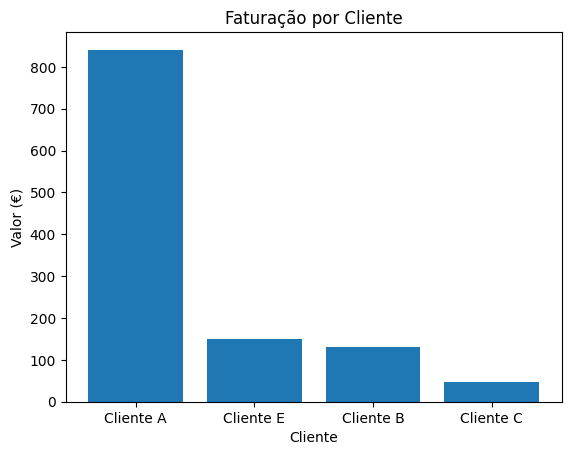

In [13]:
plt.bar(kpi_top_clientes.index, kpi_top_clientes.values)
plt.title("Faturação por Cliente")
plt.ylabel("Valor (€)")
plt.xlabel("Cliente")
plt.show()

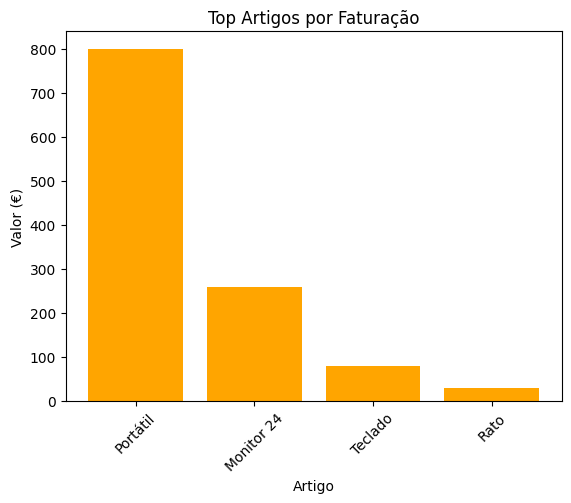

In [14]:
plt.bar(kpi_top_artigos.index, kpi_top_artigos.values, color="orange")
plt.title("Top Artigos por Faturação")
plt.ylabel("Valor (€)")
plt.xlabel("Artigo")
plt.xticks(rotation=45)
plt.show()

In [15]:
# Criar coluna ano_mes
vendas["ano_mes"] = vendas["data"].dt.to_period("M").astype(str)

# Agrupar por mês
kpi_vendas_mensais = (
    vendas.groupby("ano_mes")["valor_total"]
    .sum()
    .sort_index()
)

kpi_vendas_mensais

ano_mes
2025-01    219.39
2025-02    948.88
Name: valor_total, dtype: float64

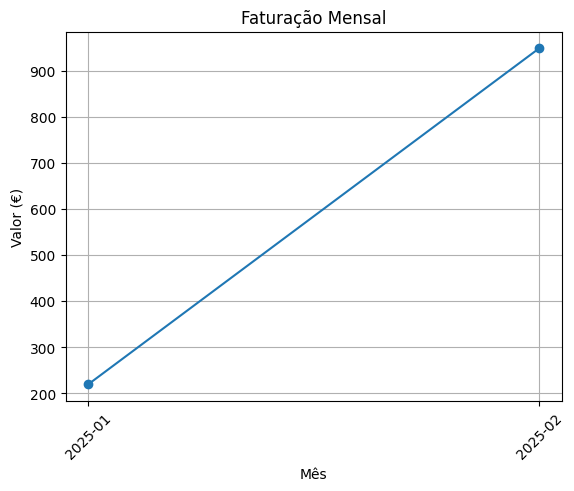

In [16]:
plt.plot(kpi_vendas_mensais.index, kpi_vendas_mensais.values, marker="o")
plt.title("Faturação Mensal")
plt.ylabel("Valor (€)")
plt.xlabel("Mês")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

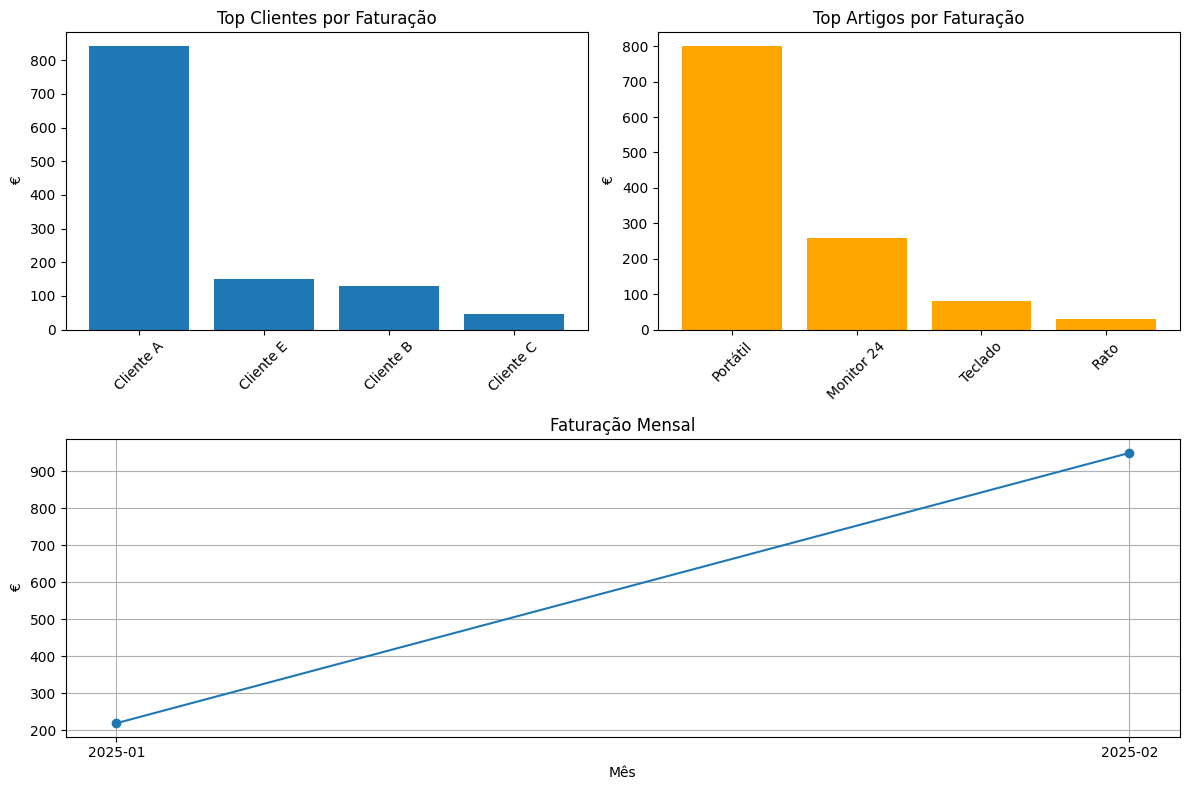

In [17]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Criar layout com 2 linhas e 2 colunas
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig)

# Gráfico 1 — Faturação por Cliente
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(kpi_top_clientes.index, kpi_top_clientes.values)
ax1.set_title("Top Clientes por Faturação")
ax1.set_ylabel("€")
ax1.tick_params(axis='x', rotation=45)

# Gráfico 2 — Top Artigos
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(kpi_top_artigos.index, kpi_top_artigos.values, color="orange")
ax2.set_title("Top Artigos por Faturação")
ax2.set_ylabel("€")
ax2.tick_params(axis='x', rotation=45)

# Gráfico 3 — Faturação Mensal (linha)
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(kpi_vendas_mensais.index, kpi_vendas_mensais.values, marker="o")
ax3.set_title("Faturação Mensal")
ax3.set_ylabel("€")
ax3.set_xlabel("Mês")
ax3.grid(True)

plt.tight_layout()
plt.show()